# 15-1. 프로젝트 : 스티커를 붙여주자


## 라이브러리 버전 확인

In [22]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
BEST_CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'best_checkpoint')
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, 'saved_model')
CHECKPOINT_30_PATH = os.path.join(PROJECT_PATH, 'checkpoints_30')


DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.6.0
1.21.4
4.5.3


## Step 1. 스티커 구하기 혹은 만들기

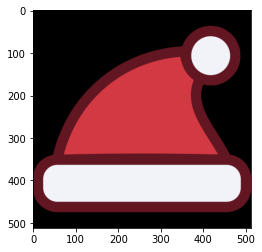

In [185]:
STICKER_PATH = os.path.join(PROJECT_PATH, 'santa.png')

sticker = cv2.imread(STICKER_PATH)
plt.imshow(cv2.cvtColor(sticker, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. SSD 모델을 통해 얼굴 bounding box 찾기

### NMS 함수 설정

In [46]:
# 가장 IoU가 높은 bounding box 선택

def compute_nms(boxes, scores, nms_threshold=0.6, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)



def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)


def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

### inference 함수 설정

In [7]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params



def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes


def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

### dafault box 함수 설정

In [9]:
# default box 정보 만들기

BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [11]:
# feature map + default box 생성 코드 함수로 구현

def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

### 자카드 유사도 구하기

In [15]:
# 교집합 구하기

def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]


# 자카드 유사도 구하기

def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

### 이미지 테스트

In [87]:
def img_test(img_path):

    img_raw = cv2.imread(img_path)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

In [57]:
# 모델 로드
model = tf.keras.models.load_model(MODEL_SAVE_PATH)
filepath = os.path.join(CHECKPOINT_30_PATH, 'weights_epoch_050.h5')
model.load_weights(filepath)

print("Model loaded successfully.")

Model loaded successfully.


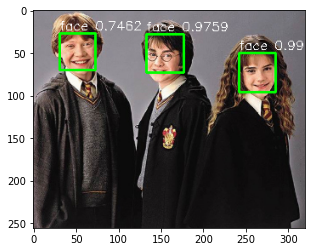

In [89]:
TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'test_image4.jpg')

img_test(TEST_IMAGE_PATH)

## Step 3. dlib 을 이용한 landmark 찾기 (선택사항)  
- 랜드마크 적용이 힘들어서 추후에 다시 도전

In [75]:
import dlib

def detect_landmarks(img_path):
    # 이미지 읽기 및 전처리
    img_raw = cv2.imread(img_path)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    # SSD 모델로 얼굴 탐지
    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
    predictions = model.predict(img[np.newaxis, ...])
    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    # 랜드마크 추출
    for box in pred_boxes:
        cx, cy, width, height = box
        x1 = int((cx - width / 2) * IMAGE_WIDTH)
        y1 = int((cy - height / 2) * IMAGE_HEIGHT)
        x2 = int((cx + width / 2) * IMAGE_WIDTH)
        y2 = int((cy + height / 2) * IMAGE_HEIGHT)

        # 바운딩 박스에 해당하는 얼굴 영역 크롭
        face_roi = img_raw[y1:y2, x1:x2]

        # 랜드마크 검출
        rect = dlib.rectangle(x1, y1, x2, y2)
        landmarks = landmark_predictor(img_raw, rect)

        # 랜드마크 시각화
        for n in range(68):  # 68개 랜드마크
            x, y = landmarks.part(n).x, landmarks.part(n).y
            cv2.circle(img_raw, (x, y), 2, (0, 255, 0), -1)

    # 결과 이미지 출력
    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

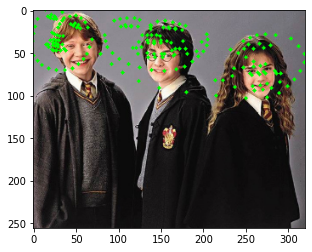

In [76]:
TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'test_image4.jpg')

detect_landmarks(TEST_IMAGE_PATH)

랜드마크가 얼굴을 전혀 잡지 못함 => 일단 패스..

## Step 4. 스티커 합성 사진 생성하기

In [198]:
def img_test_with_sticker(img_path, sticker_img_path):
    """
    SSD 모델 예측과 바운딩 박스 위에 스틱 이미지 합성하기.
    
    Parameters:
    - img_path: 테스트할 이미지 경로
    - stick_img_path: 바운딩 박스 위에 합성할 이미지 경로
    """
    # 원본 이미지 불러오기
    img_raw = cv2.imread(img_path)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    # 이미지 전처리
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    # 기본 박스 생성 및 예측 수행
    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
    predictions = model.predict(img[np.newaxis, ...])

    # 바운딩 박스 후처리
    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    # 스티커 이미지 불러오기
    sticker_img = cv2.imread(sticker_img_path)

    # 이미지 크기 얻기
    img_height, img_width, _ = img_raw.shape

    # 바운딩 박스 위에 스티커 이미지 합성
    for box_index in range(len(pred_boxes)):
        box = pred_boxes[box_index]
        
        # 정규화된 좌표를 픽셀 좌표로 변환
        x_min, y_min, x_max, y_max = box
        x_min = int(x_min * img_width)
        y_min = int(y_min * img_height) - (img_height * 0.1)
        x_max = int(x_max * img_width)
        y_max = int(y_max * img_height) - (img_height * 0.1)
        
        # 스티커 이미지 합성 함수 호출
        img_raw = overlay_image_on_bbox(img_raw, sticker_img, [x_min, y_min, x_max, y_max], alpha=0.7)

    # 결과 시각화
    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

def overlay_image_on_bbox(base_image, overlay_image, bbox, alpha=0.7):
    """
    바운딩 박스 위에 이미지를 합성하는 함수.
    
    Parameters:
    - base_image: 원본 이미지 (numpy array)
    - overlay_image: 합성할 이미지 (numpy array)
    - bbox: 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
    - alpha: 합성 투명도 (0: 완전히 투명, 1: 완전히 불투명)
    """
    x_min, y_min, x_max, y_max = map(int, bbox)
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min

    # 바운딩 박스 크기가 유효한지 확인
    if bbox_width <= 0 or bbox_height <= 0:
        print(f"Invalid bounding box: {bbox}")
        return base_image  # 크기가 유효하지 않으면 원본 이미지를 그대로 반환

    # 합성 이미지 크기 조정
    overlay_resized = cv2.resize(overlay_image, (bbox_width, bbox_height))

    # 합성할 영역 추출
    base_crop = base_image[y_min:y_max, x_min:x_max]

    mask = overlay_resized == 0  # 스티커 이미지의 값이 0인 부분을 마스크로 사용
    blended = np.where(mask, base_crop, cv2.addWeighted(base_crop, 0.5, overlay_resized, 0.5, 0))

    # 원본 이미지에 합성된 영역 적용
    base_image[y_min:y_max, x_min:x_max] = blended

    return base_image

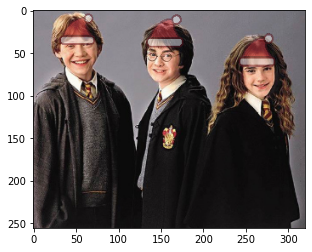

In [199]:
img_test_with_sticker(TEST_IMAGE_PATH, STICKER_PATH)

## 회고

- 우선 SSD 모델의 개념과 이를 구현한 코드를 잘 매치시켜서 이해하지 못해서 끝까지 코드를 이해하는 시간이 더 필요하다.  
- SSD 모델을 최적화 시키는 과정도 지금까지 해오던 방식과 달랐기 때문에 하면서도 확신이 없었다.  
- 최적화를 위해 학습률이나 옵티마이저를 변경하는 방법 외에 더 적합한 방법이 있는지 궁금하다.  


- 예전에 했던 스티커 붙이는 예제도 다시 보니 잘 기억이 나지 않았다.  
- dlib 라이브러리 대신 바운딩 박스와 접목하는 과정도 어려워서 결국 np.where 외의 코드는 별로 활용하지 못했다. 예제 다시 보고 충분히 활용해 봐야겠다!


- TFRecord 부분은 퍼실님께서 나중에 활용해보라고 하셨는데 어떻게 응용할 수 있는지 찾아봐야겠다.